
# Chatbot


## 准备工作

数据集下载
[here](https://zissou.infosci.cornell.edu/convokit/datasets/movie-corpus/movie-corpus.zip)  
然后将下载的movie-corpus文件夹放到当前目录下的data/中

In [2]:
# 导入必要的库
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import json


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

## 加载数据


In [3]:
# 查看数据的原始格式
corpus_name = "movie-corpus"
corpus = os.path.join("data", corpus_name)

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines(os.path.join(corpus, "utterances.jsonl"))

b'{"id": "L1045", "conversation_id": "L1044", "text": "They do not!", "speaker": "u0", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "not", "tag": "RB", "dep": "neg", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": "L1044", "timestamp": null, "vectors": []}\n'
b'{"id": "L1044", "conversation_id": "L1044", "text": "They do to!", "speaker": "u2", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "to", "tag": "TO", "dep": "dobj", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": null, "timestamp": null, "vectors": []}\n'
b'{"id": "L985", "conversation_id": "L984", "text": "I hope so.", "speaker": "u0", "meta": {

这些数据是以JSON格式表示的每条对话的元数据。每个JSON对象代表一条对话中的一条句子，具有以下字段：

- `"id"`: 句子的唯一标识符。
- `"conversation_id"`: 对话的唯一标识符，多个句子具有相同的conversation_id表示它们属于同一对话。
- `"text"`: 句子的文本内容。
- `"speaker"`: 发言者的标识符。
- `"meta"`: 元数据，包含有关句子的附加信息。
- `"reply-to"`: 句子回复的先前句子的id，如果为空则表示这是对话的起始句子。
- `"timestamp"`: 句子的时间戳，可以是日期或时间的表示。
- `"vectors"`: 句子的向量表示，可能在这个数据集中为空列表。

这些数据提供了对话的结构和发言者之间的互动关系。可以通过这些数据构建出完整的对话，并进行进一步的分析和处理。

### 数据处理

对原始数据文件``utterances.jsonl``进行数据处理，每行包含一对query-response sentense,用制表符(\t)分隔。

In [3]:
# 分割文件并创建lines和conversations
def loadLinesAndConversations(fileName):
    lines = {}
    conversations = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            lineJson = json.loads(line)
            # 提取每行的字段，包含lineID,characterID和text
            lineObj = {}
            lineObj["lineID"] = lineJson["id"]
            lineObj["characterID"] = lineJson["speaker"]
            lineObj["text"] = lineJson["text"]
            lines[lineObj['lineID']] = lineObj

            # 提取每个conversation的字段，包含conversationID,movieID和lines
            # 如果当前句子的conversationID不在conversations中，表示是新的对话
            if lineJson["conversation_id"] not in conversations:
                convObj = {}
                convObj["conversationID"] = lineJson["conversation_id"]
                convObj["movieID"] = lineJson["meta"]["movie_id"]
                convObj["lines"] = [lineObj]
            # 如果当前句子的conversationID已经在conversations中，表示是对话中的另一句，加入已有对话中
            else:
                convObj = conversations[lineJson["conversation_id"]]
                convObj["lines"].insert(0, lineObj)
            conversations[convObj["conversationID"]] = convObj

    return lines, conversations


# 从每个conversations中提取成对的query-response sentenses
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations.values():
        # 遍历对话中的每一个句子，忽略最后一个句子（因为没有response）
        for i in range(len(conversation["lines"]) - 1): 
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # 如果有空句子就去掉
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

接下来用上面的两个函数进行数据预处理，结果文件命名为
``formatted_movie_lines.txt``.

In [4]:
# 定义文件
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = '\t'
# 对分隔符'\t'进行decode
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# 初始化dict lines和conversations
lines = {}
conversations = {}
# Load lines and conversations
print("\nProcessing corpus into lines and conversations...")
lines, conversations = loadLinesAndConversations(os.path.join(corpus, "utterances.jsonl"))

# 输出到一个新的csv文件
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    # 使用extractSentencePairs函数从conversations中提取成对的query-response sentenses
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

print("\nSample lines from file:")
printLines(datafile)


Processing corpus into lines and conversations...

Writing newly formatted file...

Sample lines from file:
b'They do to!\tThey do not!\r\n'
b'She okay?\tI hope so.\r\n'
b"Wow\tLet's go.\r\n"
b'"I\'m kidding.  You know how sometimes you just become this ""persona""?  And you don\'t know how to quit?"\tNo\r\n'
b"No\tOkay -- you're gonna need to learn how to lie.\r\n"
b"I figured you'd get to the good stuff eventually.\tWhat good stuff?\r\n"
b'What good stuff?\t"The ""real you""."\r\n'
b'"The ""real you""."\tLike my fear of wearing pastels?\r\n'
b'do you listen to this crap?\tWhat crap?\r\n'
b"What crap?\tMe.  This endless ...blonde babble. I'm like, boring myself.\r\n"


### 创建词典

接下来我们需要创建词典（建立词-索引的映射）。

定义一个``Voc``类，保存词-索引的映射，除此之外还记录每个词出现的次数，以及总共出现的词的个数。

其中：
- ``addWord``函数：将一个词添加到词典中
- `addSentence`函数：将一个句子中的所有词添加到词典中
- `trim`函数：去除低频词

In [5]:
# 预定义token
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # 初始有 SOS, EOS, PAD 3个token

    # 将一个句子中的所有词添加到词典中
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    # 将一个词添加到词典中
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # 删除频次小于min_count的token
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # 重新构造词典
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3

        for word in keep_words:
            self.addWord(word)

有了上面的``Voc``类我们就可以通过query-response sentense pairs来构建词典了。但是在构建之前需要进行一些预处理。


首先我们需要使用函数``unicodeToAscii``来把unicode字符变成ascii，比如把à变成a（注意本数据集只包含英文,如果是汉字则会直接丢弃）。接下来用函数``normalizeString``把所有字母变成小写同时丢弃掉除字母和常见标点(.!?)之外的所有字符。最后为了训练收敛，我们会用函数``filterPairs``去掉长度超过MAX_LENGTH的句子(句对)。

In [6]:
MAX_LENGTH = 10  # 最大长度（包括PAD、SOS、EOS之类特殊字符)

# 将Unicode字符串变成ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip()) # 变成小写，去掉前后空格，Unicode变ASCII
    s = re.sub(r"([.!?])", r" \1", s) # 在标点前添加空格，把它当作一个词
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) # 字母和标点之外的字符都变成空格
    s = re.sub(r"\s+", r" ", s).strip() # 在经过前面的处理后可能产生多个连续空格，将它们替换为一个空格
    return s

# 读取query/response pairs并进行处理，返回词典对象voc
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # 每行用'\t'切分，并调用normalizeString函数进行处理
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

# 如果both sentences in a pair 'p' 的长度小于MAX_LENGTH，return true
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# 用filterPair函数过滤太长的句对
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# 调用上面的函数，返回voc object和pairs list
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)
# 输出一些问答句对
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64313 sentence pairs
Counting words...
Counted words: 18082

pairs:
['they do to !', 'they do not !']
['she okay ?', 'i hope so .']
['wow', 'let s go .']
['what good stuff ?', 'the real you .']
['the real you .', 'like my fear of wearing pastels ?']
['do you listen to this crap ?', 'what crap ?']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['have fun tonight ?', 'tons']


另外为了收敛更快，我们可以去除掉一些低频词。方法如下:

1. 使用``voc.trim``函数去掉频次低于``MIN_COUNT``的单词。
2. 去掉包含低频词的句子。

In [7]:
MIN_COUNT = 3 # 低频词阈值

def trimRareWords(voc, pairs, MIN_COUNT):
    # 去掉voc中频次小于MIN_COUNT的词
    voc.trim(MIN_COUNT)
    keep_pairs = [] # 存放保留的sentence pairs
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # 检查query中是否包含低频词
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # 检查response中是否包含低频词
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # 如果query-response中都只包含高频词，保留
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 7833 / 18079 = 0.4333
Trimmed from 64313 pairs to 53131, 0.8261 of total


## 为模型准备数据

前面我们构建了词典，并且对训练数据进行预处理并且滤掉一些句对，但是模型最终用到的是Tensor。最简单的办法是一次处理一个句对，那么上面得到的句对直接就可以使用。但是为了加快训练速度，尤其是重复利用GPU的并行能力，我们需要一次处理一个batch的数据。

对于某些问题，比如图像来说，输入可能是固定大小的(或者通过预处理缩放成固定大小），但是对于文本来说，我们很难把一个二十个词的句子”缩放”成十个词同时还保持语义不变。但是为了充分利用GPU等计算资源，我们又必须变成固定大小的Tensor，因此我们使用Padding的技巧，把短的句子在EOS_token后补充上零使得输入大小是(batch, max_length)，这样通过一次就能实现一个batch数据的forward或者backward计算。当然padding的部分的结果是没有意义的，比如某个句子实际长度是5，而max_length是10，那么最终forward的输出应该是第5个时刻的输出，后面5个时刻计算是无用功。方向计算梯度的时候也是类似的，我们需要从第5个时刻开始反向计算梯度。

原始的输入通常是batch个list，表示batch个句子，因此自然的表示方法为(batch, max_length)，这种表示方法第一维是batch，每移动一个下标得到的是一个样本的max_length个词(包括padding)。因为RNN的依赖关系，我们在计算t+1时刻必须知道t时刻的结果，因此我们无法用多个核同时计算一个样本的forward。但是不同样本之间是没有依赖关系的，因此我们可以在根据t时刻batch样本的当前状态计算t+1时刻batch个样本的输出和新状态，然后再计算t+2时刻，…。为了便于GPU一次取出t时刻的batch个数据，我们通常把输入从(batch, max_length)转置成(max_length, batch)，这样使得t时刻的batch个数据在内存(显存)中是连续的，从而读取效率更高。这个过程如下图所示：

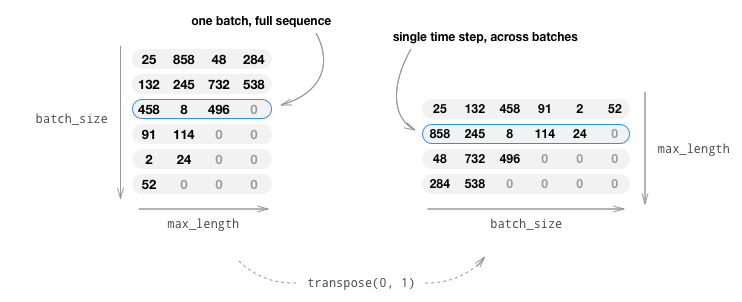

原始输入的大小是(batch=6, max_length=4)，转置之后变成(4,6)。这样某个时刻的6个样本数据在内存中是连续的。

为了实现上述处理，需要实现一些函数：
- `inputVar`函数把batch个句子padding后变成一个LongTensor，大小是(max_length, batch)，同时会返回一个大小是batch的list lengths，说明每个句子的实际长度，这个参数后面会传给PyTorch，从而在forward和backward计算的时候使用实际的长度。
- `outputVar`函数和`inputVar`类似，但是它输出的第二个参数不是lengths，而是一个大小为(max_length, batch)的mask矩阵(tensor)，某位是0表示这个位置是padding，1表示不是padding，这样做的目的是后面计算方便。当然这两种表示是等价的，只不过lengths表示更加紧凑，而mask矩阵和outputVar直接相乘就可以把padding的位置给mask(变成0)掉，这在计算loss时会非常方便。
- `batch2TrainData` 则利用上面的两个函数把一个batch的sentense pairs处理成合适的输入和输出Tensor。

In [8]:
# 把句子的词变成ID
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]

# l是多个长度不同句子(list)，使用zip_longest padding成定长，长度为最长句子的长度。
def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

# l是二维的padding后的list
# 返回m和l的大小一样，如果某个位置是padding，那么值为0，否则为1
def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# 把输入句子变成ID，然后再padding，同时返回lengths这个list，标识实际长度。
# 返回的padVar是一个LongTensor，shape是(batch, max_length)，
# lengths是一个list，长度为(batch,)，表示每个句子的实际长度。
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# 对输出句子进行padding，然后用binaryMatrix得到每个位置是padding(0)还是非padding，
# 同时返回最大最长句子的长度(也就是padding后的长度)
# 返回值padVar是LongTensor，shape是(batch, max_target_length)
# mask是ByteTensor，shape也是(batch, max_target_length)
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# 处理一个batch的sentense pairs
def batch2TrainData(voc, pair_batch):
    # 按照句子的长度(词数)排序
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# 示例输出
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[  33,  175,   24,   19,   19],
        [  14,   84,  146,  109,   10],
        [  14,   85,   24,   24,    2],
        [  14,  845,  111,  297,    0],
        [  11,   10,  561,    6,    0],
        [ 200,    2,    2,    2,    0],
        [1362,    0,    0,    0,    0],
        [  14,    0,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
lengths: tensor([9, 6, 6, 6, 3])
target_variable: tensor([[  72,   11,   61,   11,   24],
        [ 344,  200, 1342,  200,  753],
        [  14,  514,   61,  898,   22],
        [   2,   14,   24,   24, 4448],
        [   0,    2,  111,   79,   10],
        [   0,    0,   14,  376,    2],
        [   0,    0,    2,    6,    0],
        [   0,    0,    0,    2,    0]])
mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True],
        [False, False

我们可以看到input_variable的每一列表示一个样本，而每一行表示batch(5)个样本在这个时刻的值。而lengths表示真实的长度。类似的target_variable也是每一列表示一个样本，而mask的shape和target_variable一样，如果某个位置是0，则表示padding。

## 定义模型

### Seq2Seq Model

我们这个chatbot的核心是一个sequence-to-sequence(seq2seq)模型。 seq2seq模型的输入是一个变长的序列，而输出也是一个变长的序列。而且这两个序列的长度并不相同。可以使用Encoder和Decoder两个RNN来进行实现。如下图所示：
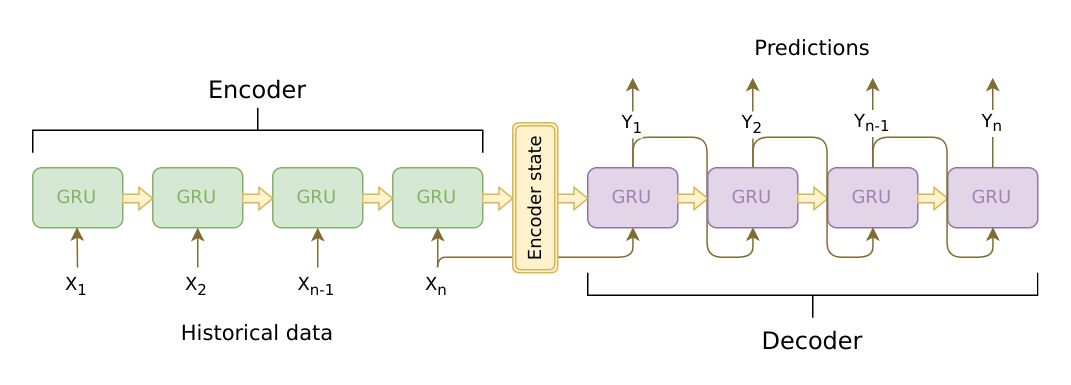

其中，Encoder把变长的输入序列编码成一个固定长度的context向量，我们一般可以认为这个向量包含了输入句子的语义。而Decoder的初始隐状态是Encoder的输出context向量，输入是表示句子开始的特殊Token``SOS_token``，然后用RNN计算第一个时刻的输出，接着用第一个时刻的输出和隐状态计算第二个时刻的输出和新的隐状态...，直到某个时刻输出表示句子结束的特殊Token``EOS_token``或者长度超过一个阈值。

### Encoder(双向GRU)

Encoder是个RNN，它会遍历输入的每一个Token(词)，每个时刻的输入是上一个时刻的隐状态和输入，然后会有一个输出和新的隐状态。这个新的隐状态会作为下一个时刻的输入隐状态。每个时刻都有一个输出，对于seq2seq模型来说，我们通常只保留最后一个时刻的隐状态，认为它编码了整个句子的语义，但是后面我们会用到Attention机制，它还会用到Encoder每个时刻的输出。Encoder处理结束后会把最后一个时刻的隐状态作为Decoder的初始隐状态。


实际我们通常使用多层的Gated Recurrent Unit(GRU)或者LSTM来作为Encoder，这里使用GRU，此外我们会使用双向的RNN，如下图所示：
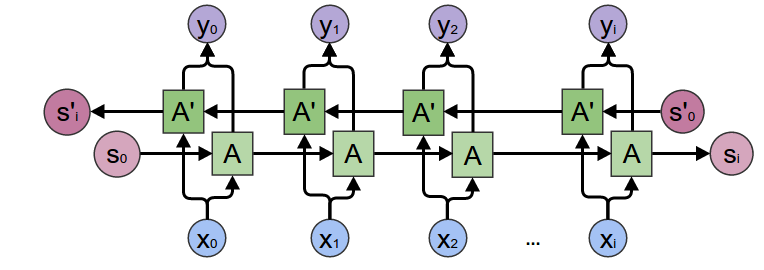

注意在接入RNN之前会有一个embedding层，用来把每一个词(ID或者one-hot向量)映射成一个连续的稠密的向量，我们可以认为这个向量编码了一个词的语义。在我们的模型里，我们把它的大小定义成和RNN的隐状态大小一样(但是并不是一定要一样)。有了Embedding之后，模型会把相似的词编码成相似的向量(距离比较近)。


最后，为了把padding的batch数据传给RNN，我们需要使用``nn.utils.rnn.pack_padded_sequence`` ``nn.utils.rnn.pad_packed_sequence``两个函数来进行pack和unpack，后面我们会详细介绍它们。

**计算过程:**
1. 把词的ID通过Embedding层变成向量。 
2. 把padding后的数据进行pack。 
3. 传入GRU进行Forward计算。
4. Unpack计算结果。
5. 把双向GRU的结果向量加起来。 
6. 返回(所有时刻的)输出和最后时刻的隐状态。

**输入:**

-  ``input_seq``: 一个batch的输入句子，shape是(max_length, batch_size)。
-  ``input_lengths``: 一个长度为batch的list，表示句子的实际长度。
-  ``hidden``:  初始化隐状态(通常是零)，shape是(n_layers x num_directions, batch_size, hidden_size)。

**输出:**

-  ``outputs``: 最后一层GRU的输出向量(双向的向量加在了一起)，shape是(max_length, batch_size, hidden_size)。
-  ``hidden``: 最后一个时刻的隐状态，shape是(n_layers x num_directions, batch_size, hidden_size)。

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # 初始化GRU，这里输入和hidden大小都是hidden_size，因为我们这里假设embedding层的输出大小是hidden_size
        # 如果只有一层，那么不进行Dropout，否则使用传入的参数dropout进行GRU的Dropout
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # 输入是(max_length, batch)，Embedding之后变成(max_length, batch, hidden_size)
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        # 因为RNN(GRU)需要知道实际的长度，所以PyTorch提供了一个函数pack_padded_sequence把输入向量和长度pack到一个对象PackedSequence里，这样便于使用。
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # 通过GRU进行forward计算，需要传入输入和隐变量
        # 如果传入的输入是一个Tensor (max_length, batch, hidden_size)
        # 那么输出outputs是(max_length, batch, hidden_size*num_directions)。
        # 第三维是hidden_size和num_directions的混合，它们实际排列顺序是num_directions在前面，因此我们可以使用outputs.view(seq_len, batch, num_directions, hidden_size)得到4维的向量。
        # 其中第三维是方向，第四位是隐状态。

        # 而如果输入是PackedSequence对象，那么输出outputs也是一个PackedSequence对象，我们需要用
        # 函数pad_packed_sequence把它变成一个shape为(max_length, batch, hidden*num_directions)的向量以及
        # 一个list，表示输出的长度，当然这个list和输入的input_lengths完全一样，因此通常我们不需要它。
        outputs, hidden = self.gru(packed, hidden)
        # 参考前面的注释，我们得到outputs为(max_length, batch, hidden*num_directions)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # 我们需要把输出的num_directions双向的向量加起来
        # 因为outputs的第三维是先放前向的hidden_size个结果，然后再放后向的hidden_size个结果
        # 所以outputs[:, :, :self.hidden_size]得到前向的结果
        # outputs[:, :, self.hidden_size:]是后向的结果
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # 返回最终的输出和最后时刻的隐状态。 
        return outputs, hidden

### Decoder(单向GRU)

Decoder也是一个RNN，它每个时刻输出一个词。每个时刻的输入是上一个时刻的隐状态和上一个时刻的输出。一开始的隐状态是Encoder最后时刻的隐状态，输入是特殊的``SOS_token``。然后使用RNN计算新的隐状态和输出第一个词，接着用新的隐状态和第一个词计算第二个词，...，直到遇到``EOS_token``，结束输出。普通的RNN Decoder的问题是它只依赖与Encoder最后一个时刻的隐状态，虽然理论上这个隐状态(context向量)可以编码输入句子的语义，但是实际会比较困难,可能产生信息损失。这在处理长输入序列时尤其如此，极大地限制了我们解码器的能力。

我们可以采用全局注意力机制来解决这个问题，在Decoder进行t时刻计算的时候，除了t-1时刻的隐状态和当前时刻的输入，还可以参考Encoder所有时刻的输入。计算方法是用当前时刻的GRU计算出的新的隐状态来计算注意力得分，首先它用一个score函数计算这个隐状态和Encoder的输出的相似度得分，得分越大，说明越应该注意这个词。然后再用softmax函数把score变成概率。以机器翻译为例，在t时刻，ht表示t时刻的GRU输出的新的隐状态，我们可以认为ht表示当前需要翻译的语义。通过计算ht与y1,…,yn的得分，如果ht与y1的得分很高，那么我们可以认为当前主要翻译词x1的语义。有很多中score函数的计算方法，如下图所示：
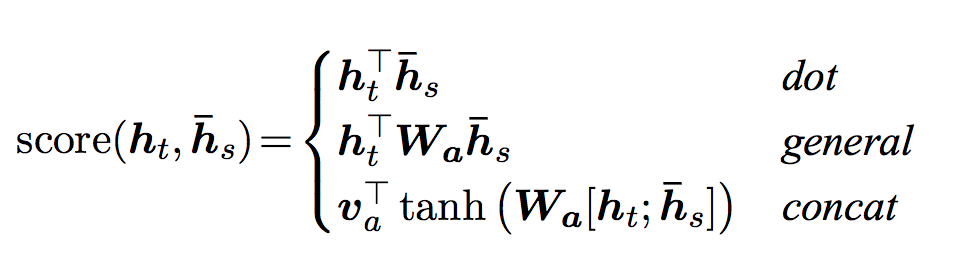
上式中ht表示t时刻的隐状态，比如第一种计算score的方法，直接计算ht
与hs的内积，内积越大，说明这两个向量越相似，因此注意力也更多的放到这个词上。第二种方法也类似，只是引入了一个可以学习的矩阵，我们可以认为它先对ht做一个线性变换，然后在与hs计算内积。而第三种方法把它们拼接起来然后用一个全连接网络来计算score。

注意，我们前面介绍的是分别计算ht和y1的内积、ht和y2的内积，…。但是为了效率，可以一次计算ht与hs=[y1,y2,…,yn]
的乘积。 计算过程如下图所示:
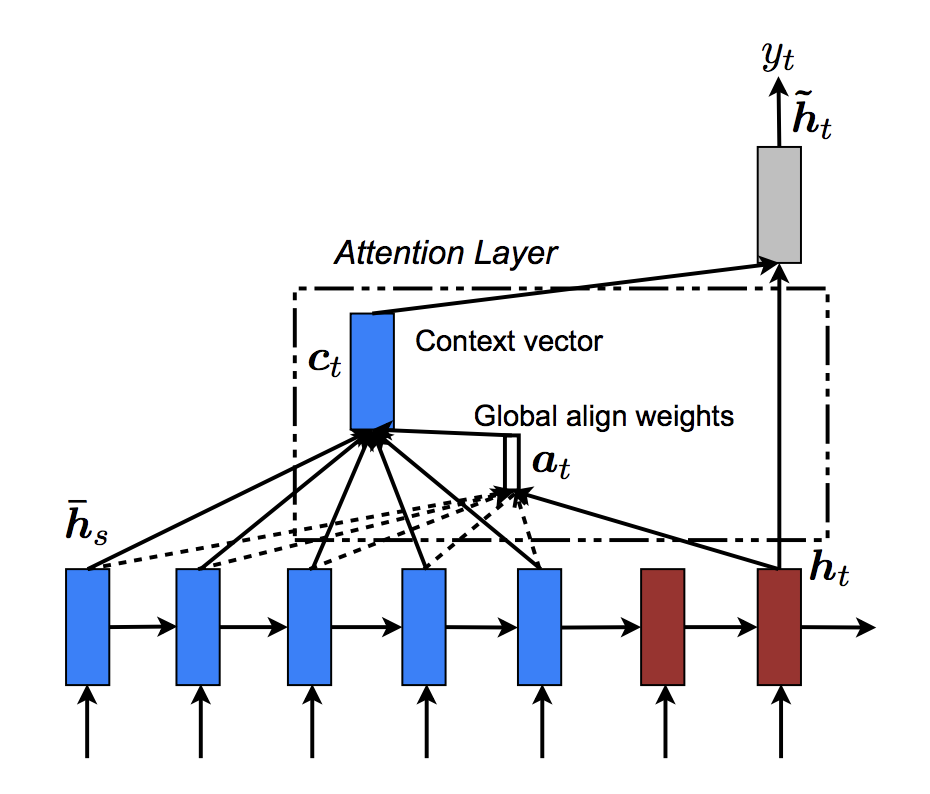

我们将注意力layer实现为一个单独的模块``Attn``,这个模块的输出是一个shape为（batch_size, 1, max_length）的softmax归一化权重张量。

In [10]:
# attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        # 输入hidden的shape是(1, batch=64, hidden_size=500)
        # encoder_outputs的shape是(input_lengths=10, batch=64, hidden_size=500)
        # hidden * encoder_output得到的shape是(10, 64, 500)，然后对第3维求和就可以计算出score。
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    # 输入是上一个时刻的隐状态hidden和所有时刻的Encoder的输出encoder_outputs
    # 输出是注意力的概率，也就是长度为input_lengths的向量，它的和加起来是1。
    def forward(self, hidden, encoder_outputs):
        # 计算注意力的score，输入hidden的shape是(1, batch=64, hidden_size=500)，
        # 表示t时刻batch数据的隐状态
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # 把attn_energies从(max_length=10, batch=64)转置成(64, 10)
        attn_energies = attn_energies.t()

        # 使用softmax函数把score变成概率，shape仍然是(64, 10)，然后用unsqueeze(1)变成(64, 1, 10) 
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

上面的代码实现了dot、general和concat三种score计算方法，分别和前面的三个公式对应，这里介绍一下的dot方法。首先这个函数的输入hidden的shape是(1, batch=64, hidden_size=500)，encoder_outputs的shape是(input_lengths=10, batch=64, hidden_size=500)。

怎么计算hidden和10个encoder输出向量的内积呢？为了简便，我们先假设batch是1，这样可以把第二维(batch维)去掉，因此hidden是(1, 500)，而encoder_outputs是(10, 500)。内积的定义是两个向量对应位相乘然后相加，但是encoder_outputs是10个500维的向量。当然我们可以写一个for循环来计算，但是效率很低。这里用到一个小的技巧，利用broadcasting，hidden * encoder_outputs可以理解为把hidden从(1,500)复制成(10, 500)（当然实际实现并不会这么做），然后两个(10, 500)的矩阵进行乘法。注意，这里的乘法不是矩阵乘法，而是所谓的Hadamard乘法，其实就是把对应位置的乘起来。

因此hidden * encoder_outputs就可以把hidden向量(500个数)与encoder_outputs的10个向量(500个数)对应的位置相乘。而内积还需要把这500个乘积加起来，因此后面使用torch.sum(hidden * encoder_output, dim=2)，把第2维500个乘积加起来，最终得到10个score值。当然我们实际还有一个batch维度，因此最终得到的attn_energies是(10, 64)。接着在forward函数里把attn_energies转置成(64, 10)，然后使用softmax函数把10个score变成概率，shape仍然是(64, 10)，为了后面使用方便，我们用unsqueeze(1)把它变成(64, 1, 10)。

有了注意力的子模块之后，我们就可以实现Decoder了。Encoder可以一次把一个序列输入GRU，得到整个序列的输出。但是Decoder t时刻的输入是t-1时刻的输出，在t-1时刻计算完成之前是未知的，因此只能一次处理一个时刻的数据。因此Encoder的GRU的输入是(max_length, batch, hidden_size)，而Decoder的输入是(1, batch, hidden_size)。此外Decoder只能利用前面的信息，所以只能使用单向(而不是双向)的GRU，而Encoder的GRU是双向的，如果两种的hidden_size是一样的，则Decoder的隐单元个数少了一半，为了把Encoder的最后时刻的隐状态作为Decoder的初始隐状态，需要把每个时刻双向结果加起来，这样它们的大小就能匹配了。

**计算过程:**

1. 把词ID输入Embedding层。
2. 使用单向的GRU继续Forward进行一个时刻的计算。
3. 使用新的隐状态（from (2))计算注意力权重。
4. 用注意力权重得到context向量。
5. context向量和GRU的输出拼接起来，然后再进过一个全连接网络，使得输出大小仍然是hidden_size。
6. 使用一个投影矩阵把输出从hidden_size变成词典大小，然后用softmax变成概率。
7. 返回输出和新的隐状态。

**输入:**

-  ``input_step``: shape是(1, batch_size)
-  ``last_hidden``: 上一个时刻的隐状态， shape是(n_layers x num_directions, batch_size, hidden_size)
-  ``encoder_outputs``: encoder的输出， shape是(max_length, batch_size, hidden_size)

**输出:**

-  ``output``: 当前时刻输出每个词的概率，shape是(batch_size, voc.num_words)
-  ``hidden``: 新的隐状态，shape是(n_layers x num_directions, batch_size, hidden_size)

In [11]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # 保存到self里，attn_model就是前面定义的Attn类的对象
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # 定义Decoder的layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # 注意：decoder每一步只能处理一个时刻的数据，因为t时刻计算完了才能计算t+1时刻。
        # input_step的shape是(1, 64)，64是batch，1是当前输入的词ID(来自上一个时刻的输出)
        # 通过embedding层变成(1, 64, 500)，然后进行dropout，shape不变。
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # 把embedded传入GRU进行forward计算
        # 得到rnn_output的shape是(1, 64, 500)
        # hidden是(2, 64, 500)，因为是两层的GRU，所以第一维是2。
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # 计算注意力权重， 根据前面的分析，attn_weights的shape是(64, 1, 10)
        attn_weights = self.attn(rnn_output, encoder_outputs)
        
        # encoder_outputs是(10, 64, 500) 
        # encoder_outputs.transpose(0, 1)后的shape是(64, 10, 500)
        # attn_weights.bmm后是(64, 1, 500)
        
        # bmm是批量的矩阵乘法，第一维是batch，我们可以把attn_weights看成64个(1,10)的矩阵
        # 把encoder_outputs.transpose(0, 1)看成64个(10, 500)的矩阵
        # 那么bmm就是64个(1, 10)矩阵 x (10, 500)矩阵，最终得到(64, 1, 500)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # 把context向量和GRU的输出拼接起来
        # rnn_output从(1, 64, 500)变成(64, 500)
        rnn_output = rnn_output.squeeze(0)
        # context从(64, 1, 500)变成(64, 500)
        context = context.squeeze(1)
        # 拼接得到(64, 1000)
        concat_input = torch.cat((rnn_output, context), 1)
        # self.concat是一个矩阵(1000, 500)，
        # self.concat(concat_input)的输出是(64, 500)
        # 然后用tanh把输出返回变成(-1,1)，concat_output的shape是(64, 500)
        concat_output = torch.tanh(self.concat(concat_input))
        # out是(500, 词典大小)    
        output = self.out(concat_output)
        # 用softmax变成概率，表示当前时刻输出每个词的概率。
        output = F.softmax(output, dim=1)
        # 返回 output和新的隐状态 
        return output, hidden

## 定义训练过程

### Masked 损失

forward实现之后，我们就需要计算loss。seq2seq有两个RNN，Encoder RNN是没有直接定义损失函数的，它是通过影响Decoder从而影响最终的输出以及loss。Decoder输出一个序列，前面我们介绍的是Decoder在预测时的过程，它的长度是不固定的，只有遇到EOS才结束。给定一个问答句对，我们可以把问题输入Encoder，然后用Decoder得到一个输出序列，但是这个输出序列和”真实”的答案长度并不相同。

而且即使长度相同并且语义相似，也很难直接知道预测的答案和真实的答案是否类似。那么我们怎么计算loss呢？比如输入是”What is your name?”，训练数据中的答案是”I am LiLi”。假设模型有两种预测：”I am fine”和”My name is LiLi”。从语义上显然第二种答案更好，但是如果字面上比较的话可能第一种更好。

但是让机器知道”I am LiLi”和”My name is LiLi”的语义很接近这是非常困难的，所以实际上我们通常还是通过字面上来进行比较。我们会限制Decoder的输出，使得Decoder的输出长度和”真实”答案一样，然后逐个时刻比较。Decoder输出的是每个词的概率分布，因此可以使用交叉熵损失函数。但是这里还有一个问题，因为是一个batch的数据里有一些是padding的，因此这些位置的预测是没有必要计算loss的，因此我们需要使用前面的mask矩阵把对应位置的loss去掉，我们可以通过下面的函数来实现计算Masked的loss。

In [12]:
def maskNLLLoss(inp, target, mask):
    # 计算实际的词的个数，因为padding是0，非padding是1，因此sum就可以得到词的个数
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

### 一次迭代的训练过程

函数``train``实现一个batch数据的训练。前面我们提到过，在训练的时候我们会限制Decoder的输出，使得Decoder的输出长度和”真实”答案一样长。但是我们在训练的时候如果让Decoder自行输出，那么收敛可能会比较慢，因为Decoder在t时刻的输入来自t-1时刻的输出。如果前面预测错了，那么后面很可能都会错下去。因此这里采用两个trick来帮助收敛：

1. **teacher forcing**:它不管模型在t-1时刻做什么预测都把t-1时刻的正确答案作为t时刻的输入。但是如果只用teacher forcing也有问题，因为真实的Decoder是没有老师来帮它纠正错误的。因此需要设置一个`teacher_forcing_ratio`参数随机的来确定本次训练是否teacher forcing。

2. **梯度裁剪(gradient clipping)** ：这个技巧通常是为了防止梯度爆炸(exploding gradient)，它把参数限制在一个范围之内，从而可以避免梯度的梯度过大或者出现NaN等问题。注意：虽然它的名字叫梯度裁剪，但实际它是对模型的参数进行裁剪，它把整个参数看成一个向量，如果这个向量的模大于max_norm，那么就把这个向量除以一个值使得模等于max_norm，因此也等价于把这个向量投影到半径为max_norm的球上。它的效果如下图所示：
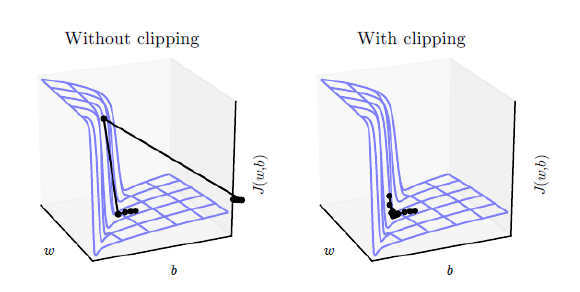

**实现步骤**

1. 把整个batch的输入传入Encoder
2. 把Decoder的输入设置为特殊的`SOS_token`，初始隐状态设置为Encoder最后时刻的隐状态
3. Decoder每次处理一个时刻的forward计算
4. 如果是teacher forcing，把上个时刻的"正确的"词作为当前输入，否则用上一个时刻的输出作为当前时刻的输入
5.  计算loss
6. 反向计算梯度
7. 对梯度进行裁剪
8. 更新模型(包括Encoder和Decoder)参数

注意：PyTorch的RNN模块(RNN, LSTM, GRU)也可以当成普通的非循环的网络来使用。在Encoder部分，我们是直接把所有时刻的数据都传入RNN，让它一次计算出所有的结果，但是在Decoder的时候(非teacher forcing)后一个时刻的输入来自前一个时刻的输出，因此无法一次计算。

In [13]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # 梯度清空
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # 设置device，从而支持GPU，当然如果没有GPU也能工作
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for RNN packing should always be on the CPU
    lengths = lengths.to("cpu")

    # 初始化变量
    loss = 0
    print_losses = []
    n_totals = 0

    # encoder的Forward计算
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Decoder的初始输入是SOS，我们需要构造(1, batch)的输入，表示第一个时刻batch个输入
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # 注意：Encoder是双向的，而Decoder是单向的，因此从下往上取n_layers个
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # 确定是否teacher forcing
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # 一次处理一个时刻 
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: 下一个时刻的输入是当前正确答案
            decoder_input = target_variable[t].view(1, -1)
            # 计算累计的loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: 下一个时刻的输入是当前模型预测概率最高的值
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # 计算累计的loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # 反向计算 
    loss.backward()

    # 对encoder和decoder进行梯度裁剪
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # 更新参数
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

### 训练

最后是把前面的代码组合起来进行训练。函数``trainIters``用于进行n_iterations次minibatch的训练。

为了保存模型，我们会保存一个tar包，包括encoder和decoder的state_dicts(参数),优化器(optimizers)的state_dicts, loss和迭代次数。这样保存模型的好处是从中恢复后我们既可以进行预测也可以进行训练(因为有优化器的参数和迭代的次数)。

In [14]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # 随机选择n_iteration个batch的数据(pair)
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # 初始化
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # 训练
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # 训练一个batch的数据
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # 打印进度
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # 保存checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

## 模型评估

模型训练完成之后，我们需要评估它的效果。最简单直接的方法就是和chatbot来聊天。因此我们需要用Decoder来生成一个响应。

### 贪心解码(Greedy decoding)算法

最简单的解码算法是贪心算法，也就是每次都选择概率最高的那个词，然后把这个词作为下一个时刻的输入，直到遇到EOS结束解码或者达到一个最大长度。但是贪心算法不一定能得到最优解，因为某个答案可能开始的几个词的概率并不太高，但是后来概率会很大。因此除了贪心算法，我们通常也可以使用Beam-Search算法，也就是每个时刻保留概率最高的Top K个结果，然后下一个时刻尝试把这K个结果输入(当然需要能恢复RNN的状态)，然后再从中选择概率最高的K个。

为了实现贪心解码算法，我们定义一个GreedySearchDecoder类。这个类的forwar的方法需要传入一个输入序列(input_seq)，其shape是(input_seq length, 1)， 输入长度input_length和最大输出长度max_length。

实现过程如下：
1. 把输入传给Encoder，得到所有时刻的输出和最后一个时刻的隐状态。
2. 把Encoder最后时刻的隐状态作为Decoder的初始状态。
3. Decoder的第一输入初始化为SOS_token。
4. 定义保存解码结果的tensor。
5. 循环直到最大解码长度。
6. 把当前输入传入Decoder。
7. 得到概率最大的词以及概率。
8. 把这个词和概率保存下来。
9. 把当前输出的词作为下一个时刻的输入。
10. 返回所有的词和概率。

In [15]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Encoder的Forward计算 
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # 把Encoder最后时刻的隐状态作为Decoder的初始值
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # 因为我们的函数都是要求(time,batch)，因此即使只有一个数据，也要做出二维的
        # Decoder的初始输入是SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # 用于保存解码结果的tensor
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # 循环，这里只使用长度限制，后面处理的时候把EOS去掉了
        for _ in range(max_length):
            # Decoder forward一步
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # decoder_outputs是(batch=1, vob_size)
            # 使用max返回概率最大的词和得分
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # 把解码结果保存到all_tokens和all_scores里
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # decoder_input是当前时刻输出的词的ID，这是个一维的向量，因为max会减少一维
            # 但是decoder要求有一个batch维度，因此用unsqueeze增加batch维度
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # 返回所有的词和得分
        return all_tokens, all_scores

### 测试对话函数

解码完成后，通过``evaluate``函数来测试从终端输入一个句子然后来看看chatbot的回复。我们需要用前面的函数来把句子分词，然后变成ID传入解码器，得到输出的ID后再转换成文字。我们需要把一个句子变成输入需要的格式——shape为(batch, max_length)，即使只有一个输入也需要增加一个batch维度。我们首先把句子分词，然后变成ID的序列，然后转置成合适的格式。此外我们还需要创建一个名为lengths的tensor，虽然只有一个，来表示输入的实际长度。接着我们构造类GreedySearchDecoder的实例searcher，然后用searcher来进行解码得到输出的ID，最后我们把这些ID变成词并且去掉EOS之后的内容。

另外一个``evaluateInput``函数作为chatbot的用户接口，当运行它的时候，它会首先提示用户输入一个句子，然后使用evaluate来生成回复。然后继续对话直到用户输入”q”或者”quit”。如果用户输入的词不在词典里，我们会输出错误信息(当然还有一种办法是忽略这些词)然后提示用户重新输入。

In [16]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # 创建lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # 转置 
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # 放到合适的设备上(比如GPU)
    input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")
    # 用searcher解码
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # 得到用户终端的输入
            input_sentence = input('> ')
            # 如果用户输入的是'q'或者'quit',直接退出
            if input_sentence == 'q' or input_sentence == 'quit': break
            # 句子归一化
            input_sentence = normalizeString(input_sentence)
            # 生成响应Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # 去掉EOS后面的内容
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))
        # 如果用户输入的词不在词典里，输出错误信息
        except KeyError:
            print("Error: Encountered unknown word.")

## 训练和测试模型

最后可以训练模型和进行评测了。

无论是训练模型还是测试对话，我们都需要初始化encoder和decoder模型参数。在下面的代码，我们从头开始训练模型或者从某个checkpoint加载模型。

In [17]:
# 配置模型
model_name = 'cb_model'
# attn_model = 'dot'
attn_model = 'general' # 效果比较好
# attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# 从哪个checkpoint恢复，如果是None，那么从头开始训练
loadFilename = None
checkpoint_iter = 4000

Sample code to load from a checkpoint:

```python
loadFilename = os.path.join(save_dir, model_name, corpus_name,
                    '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
                    '{}_checkpoint.tar'.format(checkpoint_iter))
```


In [18]:
# 如果提供了checkpoint，则加载模型
if loadFilename:
    # 如果train和load model在同一个device上
    checkpoint = torch.load(loadFilename)
    # 如果不在同一个device上，例如checkpoint是在GPU上得到的，但是我们现在又用CPU来训练或者测试，那么使用下面这行代码
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# 初始化word embedding
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# 初始化encoder和decoder模型
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


### 训练

使用下面的代码进行训练，需要设置一些训练的超参数。初始化优化器，最后调用函数``trainIters``进行训练。

In [19]:
# 配置训练的超参数和优化器 
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 8000
print_every = 1
save_every = 500

# 设置进入训练模式，从而开启dropout
encoder.train()
decoder.train()

# 初始化优化器 
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# 如果有CUDA则进行设置
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

# 开始训练
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 1; Percent complete: 0.0%; Average loss: 8.9531
Iteration: 2; Percent complete: 0.0%; Average loss: 8.8048
Iteration: 3; Percent complete: 0.0%; Average loss: 8.5796
Iteration: 4; Percent complete: 0.0%; Average loss: 8.2083
Iteration: 5; Percent complete: 0.1%; Average loss: 7.7194
Iteration: 6; Percent complete: 0.1%; Average loss: 7.1974
Iteration: 7; Percent complete: 0.1%; Average loss: 6.8236
Iteration: 8; Percent complete: 0.1%; Average loss: 6.6801
Iteration: 9; Percent complete: 0.1%; Average loss: 6.4482
Iteration: 10; Percent complete: 0.1%; Average loss: 6.1988
Iteration: 11; Percent complete: 0.1%; Average loss: 5.8393
Iteration: 12; Percent complete: 0.1%; Average loss: 5.5552
Iteration: 13; Percent complete: 0.1%; Average loss: 5.5819
Iteration: 14; Percent complete: 0.1%; Average loss: 5.5546
Iteration: 15; Percent complete: 0.1%; Average loss: 5.6668
Iteration: 16; Percent complete: 0.2%

Iteration: 138; Percent complete: 1.4%; Average loss: 4.0676
Iteration: 139; Percent complete: 1.4%; Average loss: 4.4064
Iteration: 140; Percent complete: 1.4%; Average loss: 4.2326
Iteration: 141; Percent complete: 1.4%; Average loss: 4.4371
Iteration: 142; Percent complete: 1.4%; Average loss: 4.2720
Iteration: 143; Percent complete: 1.4%; Average loss: 4.1634
Iteration: 144; Percent complete: 1.4%; Average loss: 4.2889
Iteration: 145; Percent complete: 1.5%; Average loss: 4.1135
Iteration: 146; Percent complete: 1.5%; Average loss: 4.3574
Iteration: 147; Percent complete: 1.5%; Average loss: 4.2575
Iteration: 148; Percent complete: 1.5%; Average loss: 4.4054
Iteration: 149; Percent complete: 1.5%; Average loss: 4.2702
Iteration: 150; Percent complete: 1.5%; Average loss: 4.0946
Iteration: 151; Percent complete: 1.5%; Average loss: 4.3166
Iteration: 152; Percent complete: 1.5%; Average loss: 4.3130
Iteration: 153; Percent complete: 1.5%; Average loss: 4.3294
Iteration: 154; Percent 

Iteration: 273; Percent complete: 2.7%; Average loss: 3.7445
Iteration: 274; Percent complete: 2.7%; Average loss: 3.8393
Iteration: 275; Percent complete: 2.8%; Average loss: 3.7377
Iteration: 276; Percent complete: 2.8%; Average loss: 3.9515
Iteration: 277; Percent complete: 2.8%; Average loss: 3.8214
Iteration: 278; Percent complete: 2.8%; Average loss: 4.0754
Iteration: 279; Percent complete: 2.8%; Average loss: 3.8793
Iteration: 280; Percent complete: 2.8%; Average loss: 4.0483
Iteration: 281; Percent complete: 2.8%; Average loss: 3.9954
Iteration: 282; Percent complete: 2.8%; Average loss: 3.7710
Iteration: 283; Percent complete: 2.8%; Average loss: 3.6485
Iteration: 284; Percent complete: 2.8%; Average loss: 3.9679
Iteration: 285; Percent complete: 2.9%; Average loss: 4.0510
Iteration: 286; Percent complete: 2.9%; Average loss: 3.7865
Iteration: 287; Percent complete: 2.9%; Average loss: 3.8659
Iteration: 288; Percent complete: 2.9%; Average loss: 3.7833
Iteration: 289; Percent 

Iteration: 409; Percent complete: 4.1%; Average loss: 3.8285
Iteration: 410; Percent complete: 4.1%; Average loss: 3.6867
Iteration: 411; Percent complete: 4.1%; Average loss: 3.9019
Iteration: 412; Percent complete: 4.1%; Average loss: 3.6793
Iteration: 413; Percent complete: 4.1%; Average loss: 3.8525
Iteration: 414; Percent complete: 4.1%; Average loss: 3.9232
Iteration: 415; Percent complete: 4.2%; Average loss: 3.9800
Iteration: 416; Percent complete: 4.2%; Average loss: 3.6739
Iteration: 417; Percent complete: 4.2%; Average loss: 3.9858
Iteration: 418; Percent complete: 4.2%; Average loss: 3.5612
Iteration: 419; Percent complete: 4.2%; Average loss: 3.7511
Iteration: 420; Percent complete: 4.2%; Average loss: 3.4203
Iteration: 421; Percent complete: 4.2%; Average loss: 3.9686
Iteration: 422; Percent complete: 4.2%; Average loss: 3.7526
Iteration: 423; Percent complete: 4.2%; Average loss: 3.4955
Iteration: 424; Percent complete: 4.2%; Average loss: 3.7179
Iteration: 425; Percent 

Iteration: 544; Percent complete: 5.4%; Average loss: 3.6703
Iteration: 545; Percent complete: 5.5%; Average loss: 3.8729
Iteration: 546; Percent complete: 5.5%; Average loss: 3.8283
Iteration: 547; Percent complete: 5.5%; Average loss: 3.5454
Iteration: 548; Percent complete: 5.5%; Average loss: 3.7753
Iteration: 549; Percent complete: 5.5%; Average loss: 3.5753
Iteration: 550; Percent complete: 5.5%; Average loss: 3.7333
Iteration: 551; Percent complete: 5.5%; Average loss: 3.7427
Iteration: 552; Percent complete: 5.5%; Average loss: 3.6513
Iteration: 553; Percent complete: 5.5%; Average loss: 3.6610
Iteration: 554; Percent complete: 5.5%; Average loss: 3.8445
Iteration: 555; Percent complete: 5.5%; Average loss: 3.7703
Iteration: 556; Percent complete: 5.6%; Average loss: 3.7037
Iteration: 557; Percent complete: 5.6%; Average loss: 3.5310
Iteration: 558; Percent complete: 5.6%; Average loss: 3.4648
Iteration: 559; Percent complete: 5.6%; Average loss: 3.4501
Iteration: 560; Percent 

Iteration: 681; Percent complete: 6.8%; Average loss: 3.6865
Iteration: 682; Percent complete: 6.8%; Average loss: 3.6967
Iteration: 683; Percent complete: 6.8%; Average loss: 3.7011
Iteration: 684; Percent complete: 6.8%; Average loss: 3.4158
Iteration: 685; Percent complete: 6.9%; Average loss: 3.4305
Iteration: 686; Percent complete: 6.9%; Average loss: 3.7773
Iteration: 687; Percent complete: 6.9%; Average loss: 3.6854
Iteration: 688; Percent complete: 6.9%; Average loss: 3.8234
Iteration: 689; Percent complete: 6.9%; Average loss: 3.3930
Iteration: 690; Percent complete: 6.9%; Average loss: 3.7795
Iteration: 691; Percent complete: 6.9%; Average loss: 3.6112
Iteration: 692; Percent complete: 6.9%; Average loss: 3.6361
Iteration: 693; Percent complete: 6.9%; Average loss: 3.5702
Iteration: 694; Percent complete: 6.9%; Average loss: 3.5754
Iteration: 695; Percent complete: 7.0%; Average loss: 3.6419
Iteration: 696; Percent complete: 7.0%; Average loss: 3.5891
Iteration: 697; Percent 

Iteration: 818; Percent complete: 8.2%; Average loss: 3.7803
Iteration: 819; Percent complete: 8.2%; Average loss: 3.4447
Iteration: 820; Percent complete: 8.2%; Average loss: 3.6329
Iteration: 821; Percent complete: 8.2%; Average loss: 3.5073
Iteration: 822; Percent complete: 8.2%; Average loss: 3.5665
Iteration: 823; Percent complete: 8.2%; Average loss: 3.2845
Iteration: 824; Percent complete: 8.2%; Average loss: 3.5158
Iteration: 825; Percent complete: 8.2%; Average loss: 3.3086
Iteration: 826; Percent complete: 8.3%; Average loss: 3.4302
Iteration: 827; Percent complete: 8.3%; Average loss: 3.3905
Iteration: 828; Percent complete: 8.3%; Average loss: 3.2754
Iteration: 829; Percent complete: 8.3%; Average loss: 3.2806
Iteration: 830; Percent complete: 8.3%; Average loss: 3.3771
Iteration: 831; Percent complete: 8.3%; Average loss: 3.5538
Iteration: 832; Percent complete: 8.3%; Average loss: 3.6653
Iteration: 833; Percent complete: 8.3%; Average loss: 3.5251
Iteration: 834; Percent 

Iteration: 953; Percent complete: 9.5%; Average loss: 3.5827
Iteration: 954; Percent complete: 9.5%; Average loss: 3.2770
Iteration: 955; Percent complete: 9.6%; Average loss: 3.3624
Iteration: 956; Percent complete: 9.6%; Average loss: 3.4545
Iteration: 957; Percent complete: 9.6%; Average loss: 3.3678
Iteration: 958; Percent complete: 9.6%; Average loss: 3.6275
Iteration: 959; Percent complete: 9.6%; Average loss: 3.5930
Iteration: 960; Percent complete: 9.6%; Average loss: 3.2515
Iteration: 961; Percent complete: 9.6%; Average loss: 3.4597
Iteration: 962; Percent complete: 9.6%; Average loss: 3.5706
Iteration: 963; Percent complete: 9.6%; Average loss: 3.5218
Iteration: 964; Percent complete: 9.6%; Average loss: 3.6103
Iteration: 965; Percent complete: 9.7%; Average loss: 3.5972
Iteration: 966; Percent complete: 9.7%; Average loss: 3.6950
Iteration: 967; Percent complete: 9.7%; Average loss: 3.5376
Iteration: 968; Percent complete: 9.7%; Average loss: 3.5125
Iteration: 969; Percent 

Iteration: 1085; Percent complete: 10.8%; Average loss: 3.2690
Iteration: 1086; Percent complete: 10.9%; Average loss: 3.1795
Iteration: 1087; Percent complete: 10.9%; Average loss: 3.6994
Iteration: 1088; Percent complete: 10.9%; Average loss: 3.0848
Iteration: 1089; Percent complete: 10.9%; Average loss: 3.4518
Iteration: 1090; Percent complete: 10.9%; Average loss: 3.4510
Iteration: 1091; Percent complete: 10.9%; Average loss: 3.3976
Iteration: 1092; Percent complete: 10.9%; Average loss: 3.4147
Iteration: 1093; Percent complete: 10.9%; Average loss: 3.4453
Iteration: 1094; Percent complete: 10.9%; Average loss: 3.3819
Iteration: 1095; Percent complete: 10.9%; Average loss: 3.3122
Iteration: 1096; Percent complete: 11.0%; Average loss: 3.2693
Iteration: 1097; Percent complete: 11.0%; Average loss: 3.3402
Iteration: 1098; Percent complete: 11.0%; Average loss: 3.4624
Iteration: 1099; Percent complete: 11.0%; Average loss: 3.5357
Iteration: 1100; Percent complete: 11.0%; Average loss:

Iteration: 1217; Percent complete: 12.2%; Average loss: 3.5023
Iteration: 1218; Percent complete: 12.2%; Average loss: 3.4128
Iteration: 1219; Percent complete: 12.2%; Average loss: 3.5037
Iteration: 1220; Percent complete: 12.2%; Average loss: 3.1264
Iteration: 1221; Percent complete: 12.2%; Average loss: 3.2887
Iteration: 1222; Percent complete: 12.2%; Average loss: 3.3178
Iteration: 1223; Percent complete: 12.2%; Average loss: 3.5201
Iteration: 1224; Percent complete: 12.2%; Average loss: 3.5094
Iteration: 1225; Percent complete: 12.2%; Average loss: 3.3886
Iteration: 1226; Percent complete: 12.3%; Average loss: 3.4796
Iteration: 1227; Percent complete: 12.3%; Average loss: 3.6996
Iteration: 1228; Percent complete: 12.3%; Average loss: 3.2698
Iteration: 1229; Percent complete: 12.3%; Average loss: 3.3680
Iteration: 1230; Percent complete: 12.3%; Average loss: 3.4795
Iteration: 1231; Percent complete: 12.3%; Average loss: 3.3284
Iteration: 1232; Percent complete: 12.3%; Average loss:

Iteration: 1351; Percent complete: 13.5%; Average loss: 3.3661
Iteration: 1352; Percent complete: 13.5%; Average loss: 3.7457
Iteration: 1353; Percent complete: 13.5%; Average loss: 3.5925
Iteration: 1354; Percent complete: 13.5%; Average loss: 3.3344
Iteration: 1355; Percent complete: 13.6%; Average loss: 3.3210
Iteration: 1356; Percent complete: 13.6%; Average loss: 3.4747
Iteration: 1357; Percent complete: 13.6%; Average loss: 3.4565
Iteration: 1358; Percent complete: 13.6%; Average loss: 3.2809
Iteration: 1359; Percent complete: 13.6%; Average loss: 3.5111
Iteration: 1360; Percent complete: 13.6%; Average loss: 3.2789
Iteration: 1361; Percent complete: 13.6%; Average loss: 3.1588
Iteration: 1362; Percent complete: 13.6%; Average loss: 3.3942
Iteration: 1363; Percent complete: 13.6%; Average loss: 3.4346
Iteration: 1364; Percent complete: 13.6%; Average loss: 3.3709
Iteration: 1365; Percent complete: 13.7%; Average loss: 3.1326
Iteration: 1366; Percent complete: 13.7%; Average loss:

Iteration: 1484; Percent complete: 14.8%; Average loss: 3.3845
Iteration: 1485; Percent complete: 14.8%; Average loss: 3.3622
Iteration: 1486; Percent complete: 14.9%; Average loss: 3.4686
Iteration: 1487; Percent complete: 14.9%; Average loss: 3.5560
Iteration: 1488; Percent complete: 14.9%; Average loss: 3.2994
Iteration: 1489; Percent complete: 14.9%; Average loss: 3.1247
Iteration: 1490; Percent complete: 14.9%; Average loss: 3.2896
Iteration: 1491; Percent complete: 14.9%; Average loss: 3.0443
Iteration: 1492; Percent complete: 14.9%; Average loss: 3.4688
Iteration: 1493; Percent complete: 14.9%; Average loss: 3.4420
Iteration: 1494; Percent complete: 14.9%; Average loss: 3.3457
Iteration: 1495; Percent complete: 14.9%; Average loss: 3.4212
Iteration: 1496; Percent complete: 15.0%; Average loss: 3.5125
Iteration: 1497; Percent complete: 15.0%; Average loss: 3.5994
Iteration: 1498; Percent complete: 15.0%; Average loss: 3.2054
Iteration: 1499; Percent complete: 15.0%; Average loss:

Iteration: 1615; Percent complete: 16.2%; Average loss: 3.1804
Iteration: 1616; Percent complete: 16.2%; Average loss: 3.3040
Iteration: 1617; Percent complete: 16.2%; Average loss: 3.1924
Iteration: 1618; Percent complete: 16.2%; Average loss: 3.2754
Iteration: 1619; Percent complete: 16.2%; Average loss: 3.2055
Iteration: 1620; Percent complete: 16.2%; Average loss: 3.0763
Iteration: 1621; Percent complete: 16.2%; Average loss: 3.2710
Iteration: 1622; Percent complete: 16.2%; Average loss: 3.3479
Iteration: 1623; Percent complete: 16.2%; Average loss: 3.2836
Iteration: 1624; Percent complete: 16.2%; Average loss: 3.3112
Iteration: 1625; Percent complete: 16.2%; Average loss: 3.2935
Iteration: 1626; Percent complete: 16.3%; Average loss: 3.4386
Iteration: 1627; Percent complete: 16.3%; Average loss: 3.2520
Iteration: 1628; Percent complete: 16.3%; Average loss: 3.1034
Iteration: 1629; Percent complete: 16.3%; Average loss: 3.3530
Iteration: 1630; Percent complete: 16.3%; Average loss:

Iteration: 1749; Percent complete: 17.5%; Average loss: 3.1889
Iteration: 1750; Percent complete: 17.5%; Average loss: 3.1262
Iteration: 1751; Percent complete: 17.5%; Average loss: 2.9407
Iteration: 1752; Percent complete: 17.5%; Average loss: 3.1622
Iteration: 1753; Percent complete: 17.5%; Average loss: 3.0865
Iteration: 1754; Percent complete: 17.5%; Average loss: 3.2503
Iteration: 1755; Percent complete: 17.5%; Average loss: 3.0795
Iteration: 1756; Percent complete: 17.6%; Average loss: 2.9206
Iteration: 1757; Percent complete: 17.6%; Average loss: 3.1006
Iteration: 1758; Percent complete: 17.6%; Average loss: 3.1683
Iteration: 1759; Percent complete: 17.6%; Average loss: 3.0401
Iteration: 1760; Percent complete: 17.6%; Average loss: 3.2179
Iteration: 1761; Percent complete: 17.6%; Average loss: 3.2413
Iteration: 1762; Percent complete: 17.6%; Average loss: 3.0353
Iteration: 1763; Percent complete: 17.6%; Average loss: 3.1404
Iteration: 1764; Percent complete: 17.6%; Average loss:

Iteration: 1881; Percent complete: 18.8%; Average loss: 3.2271
Iteration: 1882; Percent complete: 18.8%; Average loss: 3.3294
Iteration: 1883; Percent complete: 18.8%; Average loss: 2.9658
Iteration: 1884; Percent complete: 18.8%; Average loss: 3.1452
Iteration: 1885; Percent complete: 18.9%; Average loss: 3.2233
Iteration: 1886; Percent complete: 18.9%; Average loss: 3.0082
Iteration: 1887; Percent complete: 18.9%; Average loss: 2.9826
Iteration: 1888; Percent complete: 18.9%; Average loss: 3.0789
Iteration: 1889; Percent complete: 18.9%; Average loss: 2.9547
Iteration: 1890; Percent complete: 18.9%; Average loss: 3.1121
Iteration: 1891; Percent complete: 18.9%; Average loss: 3.0215
Iteration: 1892; Percent complete: 18.9%; Average loss: 3.2161
Iteration: 1893; Percent complete: 18.9%; Average loss: 3.1813
Iteration: 1894; Percent complete: 18.9%; Average loss: 3.0828
Iteration: 1895; Percent complete: 18.9%; Average loss: 3.4437
Iteration: 1896; Percent complete: 19.0%; Average loss:

Iteration: 2013; Percent complete: 20.1%; Average loss: 3.3942
Iteration: 2014; Percent complete: 20.1%; Average loss: 2.9285
Iteration: 2015; Percent complete: 20.2%; Average loss: 3.0388
Iteration: 2016; Percent complete: 20.2%; Average loss: 3.2020
Iteration: 2017; Percent complete: 20.2%; Average loss: 3.0150
Iteration: 2018; Percent complete: 20.2%; Average loss: 3.2678
Iteration: 2019; Percent complete: 20.2%; Average loss: 3.3659
Iteration: 2020; Percent complete: 20.2%; Average loss: 3.2617
Iteration: 2021; Percent complete: 20.2%; Average loss: 2.9888
Iteration: 2022; Percent complete: 20.2%; Average loss: 2.9670
Iteration: 2023; Percent complete: 20.2%; Average loss: 3.1558
Iteration: 2024; Percent complete: 20.2%; Average loss: 3.1800
Iteration: 2025; Percent complete: 20.2%; Average loss: 3.0232
Iteration: 2026; Percent complete: 20.3%; Average loss: 3.3136
Iteration: 2027; Percent complete: 20.3%; Average loss: 3.1513
Iteration: 2028; Percent complete: 20.3%; Average loss:

Iteration: 2145; Percent complete: 21.4%; Average loss: 3.2163
Iteration: 2146; Percent complete: 21.5%; Average loss: 3.0758
Iteration: 2147; Percent complete: 21.5%; Average loss: 3.1462
Iteration: 2148; Percent complete: 21.5%; Average loss: 2.9633
Iteration: 2149; Percent complete: 21.5%; Average loss: 3.0163
Iteration: 2150; Percent complete: 21.5%; Average loss: 2.9317
Iteration: 2151; Percent complete: 21.5%; Average loss: 3.2824
Iteration: 2152; Percent complete: 21.5%; Average loss: 3.1471
Iteration: 2153; Percent complete: 21.5%; Average loss: 3.1626
Iteration: 2154; Percent complete: 21.5%; Average loss: 3.0038
Iteration: 2155; Percent complete: 21.6%; Average loss: 3.1770
Iteration: 2156; Percent complete: 21.6%; Average loss: 3.1970
Iteration: 2157; Percent complete: 21.6%; Average loss: 3.0508
Iteration: 2158; Percent complete: 21.6%; Average loss: 3.2693
Iteration: 2159; Percent complete: 21.6%; Average loss: 3.1956
Iteration: 2160; Percent complete: 21.6%; Average loss:

Iteration: 2277; Percent complete: 22.8%; Average loss: 2.9399
Iteration: 2278; Percent complete: 22.8%; Average loss: 2.9668
Iteration: 2279; Percent complete: 22.8%; Average loss: 3.0255
Iteration: 2280; Percent complete: 22.8%; Average loss: 3.2710
Iteration: 2281; Percent complete: 22.8%; Average loss: 2.7916
Iteration: 2282; Percent complete: 22.8%; Average loss: 3.2760
Iteration: 2283; Percent complete: 22.8%; Average loss: 3.3032
Iteration: 2284; Percent complete: 22.8%; Average loss: 3.1414
Iteration: 2285; Percent complete: 22.9%; Average loss: 2.9930
Iteration: 2286; Percent complete: 22.9%; Average loss: 3.0687
Iteration: 2287; Percent complete: 22.9%; Average loss: 3.3196
Iteration: 2288; Percent complete: 22.9%; Average loss: 2.8500
Iteration: 2289; Percent complete: 22.9%; Average loss: 2.9545
Iteration: 2290; Percent complete: 22.9%; Average loss: 3.0469
Iteration: 2291; Percent complete: 22.9%; Average loss: 3.0886
Iteration: 2292; Percent complete: 22.9%; Average loss:

Iteration: 2408; Percent complete: 24.1%; Average loss: 3.0782
Iteration: 2409; Percent complete: 24.1%; Average loss: 3.0456
Iteration: 2410; Percent complete: 24.1%; Average loss: 2.8310
Iteration: 2411; Percent complete: 24.1%; Average loss: 2.9955
Iteration: 2412; Percent complete: 24.1%; Average loss: 3.0991
Iteration: 2413; Percent complete: 24.1%; Average loss: 2.8788
Iteration: 2414; Percent complete: 24.1%; Average loss: 3.0709
Iteration: 2415; Percent complete: 24.1%; Average loss: 3.1387
Iteration: 2416; Percent complete: 24.2%; Average loss: 3.0687
Iteration: 2417; Percent complete: 24.2%; Average loss: 3.0343
Iteration: 2418; Percent complete: 24.2%; Average loss: 3.0415
Iteration: 2419; Percent complete: 24.2%; Average loss: 3.0871
Iteration: 2420; Percent complete: 24.2%; Average loss: 2.8384
Iteration: 2421; Percent complete: 24.2%; Average loss: 3.0716
Iteration: 2422; Percent complete: 24.2%; Average loss: 3.1237
Iteration: 2423; Percent complete: 24.2%; Average loss:

Iteration: 2540; Percent complete: 25.4%; Average loss: 2.9310
Iteration: 2541; Percent complete: 25.4%; Average loss: 2.9793
Iteration: 2542; Percent complete: 25.4%; Average loss: 3.1186
Iteration: 2543; Percent complete: 25.4%; Average loss: 3.1829
Iteration: 2544; Percent complete: 25.4%; Average loss: 3.1552
Iteration: 2545; Percent complete: 25.4%; Average loss: 3.0129
Iteration: 2546; Percent complete: 25.5%; Average loss: 3.0168
Iteration: 2547; Percent complete: 25.5%; Average loss: 2.9369
Iteration: 2548; Percent complete: 25.5%; Average loss: 2.8113
Iteration: 2549; Percent complete: 25.5%; Average loss: 2.8312
Iteration: 2550; Percent complete: 25.5%; Average loss: 3.0154
Iteration: 2551; Percent complete: 25.5%; Average loss: 3.1912
Iteration: 2552; Percent complete: 25.5%; Average loss: 3.1282
Iteration: 2553; Percent complete: 25.5%; Average loss: 3.1111
Iteration: 2554; Percent complete: 25.5%; Average loss: 2.9048
Iteration: 2555; Percent complete: 25.6%; Average loss:

Iteration: 2671; Percent complete: 26.7%; Average loss: 3.0123
Iteration: 2672; Percent complete: 26.7%; Average loss: 2.9450
Iteration: 2673; Percent complete: 26.7%; Average loss: 2.8718
Iteration: 2674; Percent complete: 26.7%; Average loss: 3.1242
Iteration: 2675; Percent complete: 26.8%; Average loss: 3.0191
Iteration: 2676; Percent complete: 26.8%; Average loss: 2.8716
Iteration: 2677; Percent complete: 26.8%; Average loss: 3.0624
Iteration: 2678; Percent complete: 26.8%; Average loss: 2.8242
Iteration: 2679; Percent complete: 26.8%; Average loss: 2.9544
Iteration: 2680; Percent complete: 26.8%; Average loss: 3.0839
Iteration: 2681; Percent complete: 26.8%; Average loss: 2.8300
Iteration: 2682; Percent complete: 26.8%; Average loss: 2.8814
Iteration: 2683; Percent complete: 26.8%; Average loss: 2.9377
Iteration: 2684; Percent complete: 26.8%; Average loss: 2.7271
Iteration: 2685; Percent complete: 26.9%; Average loss: 3.0159
Iteration: 2686; Percent complete: 26.9%; Average loss:

Iteration: 2805; Percent complete: 28.1%; Average loss: 2.8713
Iteration: 2806; Percent complete: 28.1%; Average loss: 3.0070
Iteration: 2807; Percent complete: 28.1%; Average loss: 2.8502
Iteration: 2808; Percent complete: 28.1%; Average loss: 2.7898
Iteration: 2809; Percent complete: 28.1%; Average loss: 3.0563
Iteration: 2810; Percent complete: 28.1%; Average loss: 3.0090
Iteration: 2811; Percent complete: 28.1%; Average loss: 2.7668
Iteration: 2812; Percent complete: 28.1%; Average loss: 2.8388
Iteration: 2813; Percent complete: 28.1%; Average loss: 2.8979
Iteration: 2814; Percent complete: 28.1%; Average loss: 2.9314
Iteration: 2815; Percent complete: 28.1%; Average loss: 2.9970
Iteration: 2816; Percent complete: 28.2%; Average loss: 2.9234
Iteration: 2817; Percent complete: 28.2%; Average loss: 2.8565
Iteration: 2818; Percent complete: 28.2%; Average loss: 2.7869
Iteration: 2819; Percent complete: 28.2%; Average loss: 2.6378
Iteration: 2820; Percent complete: 28.2%; Average loss:

Iteration: 2936; Percent complete: 29.4%; Average loss: 3.0272
Iteration: 2937; Percent complete: 29.4%; Average loss: 2.8711
Iteration: 2938; Percent complete: 29.4%; Average loss: 3.0642
Iteration: 2939; Percent complete: 29.4%; Average loss: 3.0611
Iteration: 2940; Percent complete: 29.4%; Average loss: 2.9230
Iteration: 2941; Percent complete: 29.4%; Average loss: 3.0289
Iteration: 2942; Percent complete: 29.4%; Average loss: 2.8514
Iteration: 2943; Percent complete: 29.4%; Average loss: 3.2018
Iteration: 2944; Percent complete: 29.4%; Average loss: 3.0437
Iteration: 2945; Percent complete: 29.4%; Average loss: 3.0802
Iteration: 2946; Percent complete: 29.5%; Average loss: 2.7668
Iteration: 2947; Percent complete: 29.5%; Average loss: 2.7668
Iteration: 2948; Percent complete: 29.5%; Average loss: 2.7749
Iteration: 2949; Percent complete: 29.5%; Average loss: 2.6565
Iteration: 2950; Percent complete: 29.5%; Average loss: 2.9221
Iteration: 2951; Percent complete: 29.5%; Average loss:

Iteration: 3069; Percent complete: 30.7%; Average loss: 2.8357
Iteration: 3070; Percent complete: 30.7%; Average loss: 2.6751
Iteration: 3071; Percent complete: 30.7%; Average loss: 3.0996
Iteration: 3072; Percent complete: 30.7%; Average loss: 2.5588
Iteration: 3073; Percent complete: 30.7%; Average loss: 3.0123
Iteration: 3074; Percent complete: 30.7%; Average loss: 3.0504
Iteration: 3075; Percent complete: 30.8%; Average loss: 3.0255
Iteration: 3076; Percent complete: 30.8%; Average loss: 2.8493
Iteration: 3077; Percent complete: 30.8%; Average loss: 2.8736
Iteration: 3078; Percent complete: 30.8%; Average loss: 3.1545
Iteration: 3079; Percent complete: 30.8%; Average loss: 3.0984
Iteration: 3080; Percent complete: 30.8%; Average loss: 2.7254
Iteration: 3081; Percent complete: 30.8%; Average loss: 2.7603
Iteration: 3082; Percent complete: 30.8%; Average loss: 2.7375
Iteration: 3083; Percent complete: 30.8%; Average loss: 2.8938
Iteration: 3084; Percent complete: 30.8%; Average loss:

Iteration: 3200; Percent complete: 32.0%; Average loss: 2.8206
Iteration: 3201; Percent complete: 32.0%; Average loss: 2.9317
Iteration: 3202; Percent complete: 32.0%; Average loss: 2.8953
Iteration: 3203; Percent complete: 32.0%; Average loss: 2.7448
Iteration: 3204; Percent complete: 32.0%; Average loss: 3.0140
Iteration: 3205; Percent complete: 32.0%; Average loss: 2.9358
Iteration: 3206; Percent complete: 32.1%; Average loss: 3.0425
Iteration: 3207; Percent complete: 32.1%; Average loss: 2.9535
Iteration: 3208; Percent complete: 32.1%; Average loss: 2.7353
Iteration: 3209; Percent complete: 32.1%; Average loss: 2.9927
Iteration: 3210; Percent complete: 32.1%; Average loss: 2.8080
Iteration: 3211; Percent complete: 32.1%; Average loss: 2.6731
Iteration: 3212; Percent complete: 32.1%; Average loss: 2.8412
Iteration: 3213; Percent complete: 32.1%; Average loss: 2.7631
Iteration: 3214; Percent complete: 32.1%; Average loss: 2.8201
Iteration: 3215; Percent complete: 32.1%; Average loss:

Iteration: 3463; Percent complete: 34.6%; Average loss: 2.6412
Iteration: 3464; Percent complete: 34.6%; Average loss: 2.8648
Iteration: 3465; Percent complete: 34.6%; Average loss: 2.8000
Iteration: 3466; Percent complete: 34.7%; Average loss: 2.7393
Iteration: 3467; Percent complete: 34.7%; Average loss: 2.5626
Iteration: 3468; Percent complete: 34.7%; Average loss: 2.6154
Iteration: 3469; Percent complete: 34.7%; Average loss: 2.6909
Iteration: 3470; Percent complete: 34.7%; Average loss: 2.7856
Iteration: 3471; Percent complete: 34.7%; Average loss: 2.5753
Iteration: 3472; Percent complete: 34.7%; Average loss: 2.6877
Iteration: 3473; Percent complete: 34.7%; Average loss: 2.7883
Iteration: 3474; Percent complete: 34.7%; Average loss: 2.7099
Iteration: 3475; Percent complete: 34.8%; Average loss: 2.5519
Iteration: 3476; Percent complete: 34.8%; Average loss: 2.7546
Iteration: 3477; Percent complete: 34.8%; Average loss: 2.7356
Iteration: 3478; Percent complete: 34.8%; Average loss:

Iteration: 3594; Percent complete: 35.9%; Average loss: 2.7566
Iteration: 3595; Percent complete: 35.9%; Average loss: 2.6977
Iteration: 3596; Percent complete: 36.0%; Average loss: 2.5501


KeyboardInterrupt: 

### Let's chat!

运行下面的block来与训练好的模型聊天。

In [ ]:
# 进入eval模式，从而去掉dropout。
encoder.eval()
decoder.eval()

# 构造searcher对象 
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting
evaluateInput(encoder, decoder, searcher, voc)